In [102]:
# import necessary packages
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from numpy.random import shuffle
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from torchvision import transforms, datasets

In [103]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize images
        new_image = resize(image, new_shape, 0)
        # append resized images to list
        images_list.append(new_image)
    return asarray(images_list)

In [104]:
# calculate frechet inception distance between two groups of images against a model's calculations
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate FID score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [105]:
# load the generated images from our generated pickle file
with open('train_samples_500_beta0.3.pkl', 'rb') as f:
    samples = pkl.load(f)

In [106]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Apply the transformations to our dataset
data_dir = 'image_folder/'
img_size = 32
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])

# Load our MET paintings dataset
met_data = datasets.ImageFolder(data_dir, transform=transform)

In [107]:
def calc_FID_score(i):
    # Set real_images to np arrays representing tensors of our whole dataset
    real_images = []
    for tensor, _ in met_data:
        img = np.array(tensor)
        img = np.transpose(img, (1,2,0))
        real_images.append(img)
    real_images = np.asarray(real_images)

    # shuffle real_images so the FID is calculated against randomly chosen images in the dataset
    shuffle(real_images)

    # Set generated_images to np arrays representing tensors of our generated paintings
    generated_images = []
    # samples[-1] represents the images generated from our last epoch
    for s in samples[i]:
        s = (s.detach().numpy())
        s = np.transpose(s, (1,2,0))
        generated_images.append(s)
    generated_images = np.asarray(generated_images)

    # take as many real images as the number of generated images
    real_images = real_images[:len(generated_images)]
    #print('Loaded', real_images.shape, generated_images.shape)

    # convert integer to floating point values
    real_images = real_images.astype('float32')
    generated_images = generated_images.astype('float32')

    # resize all images to (299,299,3)
    real_images = scale_images(real_images, (299,299,3))
    generated_images = scale_images(generated_images, (299,299,3))
    #print('Scaled', real_images.shape, generated_images.shape)

    # pre-process images to compare to the model
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # calculate fid
    fid = calculate_fid(model, real_images, generated_images)
    #print('FID: %.3f' % fid)
    return fid

min_ = [float('inf'), -1]
FID_scores = []
for i in range(99, len(samples)):
    curr_score = calc_FID_score(i)
    if curr_score < min_[0]:
        min_ = [curr_score,i]
    FID_scores.append(curr_score)
print(min_)

[1.4218357453541595, 421]


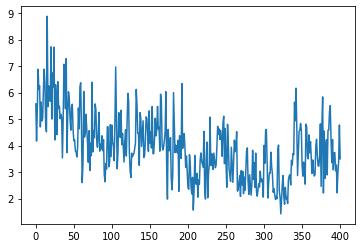

In [108]:
plt.plot(FID_scores)

In [109]:
mean = np.mean(FID_scores)
std = np.std(FID_scores)
print(mean, std)

3.9508523451214885 1.224163587287428
